In [1]:
import sys
sys.path.append('/home/emastr/phd/')

import numpy as np
import torch as pt
import torch.autograd as agrad
import matplotlib.pyplot as plt
from util.plot_tools import *
from architecture.fno_1d import *
from boundary_solvers.blobs import *
from boundary_solvers.geometry import *
from scipy.sparse.linalg import gmres, LinearOperator
from operators.stokes_operator import StokesAdjointBoundaryOp
from util.unet import *
import torch.nn as nn

In [2]:
import os
lst = os.listdir("/home/emastr/phd/data/rounded_micro_domains_w_riesz_vectors_2")
print(len(lst))

200000


In [3]:
path = lambda i: f"/home/emastr/phd/data/runs/fno_adjoint_state_dict_2022_12_02_default{i}_30000.Torch"
path2 = lambda i: f"/home/emastr/phd/data/runs/fno_big_data_{i}_{30000}.Torch"

In [4]:
data = torch.load(path(15))
default_settings = {"modes": 10,
                    "input_features": ['x','y','vx','vy'],
                    "layer_widths": None, 
                    "weight_decay": 0.}

In [5]:
settings = data["settings"]
testloss = data["testloss"]
statedic = data["state dict"]

for k in default_settings.keys():
    settings[k] = settings.pop(k, default_settings[k])
    
features = settings["input_features"]
print(settings)
# Standard features (coordinates, derivatives of parameterisation)
#if features == {'x', 'y', 'dx','dy','ddx','ddy','vx','vy'}:
#    features = ['x', 'y', 'dx','dy','ddx','ddy','vx','vy']
#elif features == {'x', 'y', 'tx', 'ty', 'c', 'vx', 'vy'}:
#    features = ['x', 'y', 'tx', 'ty', 'c', 'vx', 'vy']
#else:
#    features = ['x', 'y', 'vx', 'vy']

print(features)
    
net = FNO1d(modes=settings["modes"], 
            in_channels=len(settings["input_features"]), 
            out_channels=2, 
            layer_widths=settings["layer_widths"]) 
net.load_state_dict(statedic)


{'modes': 10, 'input_features': {'y', 'c', 'vx', 'ty', 'tx', 'vy', 'x'}, 'layer_widths': [14, 14, 14, 14], 'weight_decay': 0.0}
{'y', 'c', 'vx', 'ty', 'tx', 'vy', 'x'}


<All keys matched successfully>

In [6]:
#features == {'x', 'y', 'dx','dy','ddx','ddy','vx','vy'}
features == {'x', 'y', 'tx', 'ty', 'c', 'vx', 'vy'}
#features = {'x', 'y', 'vx', 'vy'}

True

In [7]:
def unpack_data(data):
    xlabels = ['x', 'y', 'dx', 'dy', 'ddx', 'ddy', 'vx', 'vy', 'w', 't']
    ylabels = ['rx', 'ry']
    inp = {xlabels[i]: data['X'][:, i, :] for i in range(10)}
    out = {ylabels[i]: data['Y'][:, i, :] for i in range(2)}
    return (inp, out)

def unpack(transform):
    """Decorator for if a method is supposed to act on the values of a dict."""
    def up_transform(data, *args, **kwargs):
        if type(data) == dict:
            return {k: transform(data[k], *args, **kwargs) for k in data.keys()}
        else:
            return transform(data, *args, **kwargs)
    return up_transform

@unpack
def subsample(x, idx):
    return x[idx]

@unpack
def integrate(x, w):
    return torch.cumsum(x * w, axis=len(x.shape)-1)

def subdict(dic, keys):
    return {k: dic[k] for k in keys if k in dic.keys()}

def concat_dict_entries(data):
    return torch.cat(tuple((d[:, None, :] for d in data.values())), dim=1)
    
def arclength(dx, dy, w):
    return integrate((dx**2 + dy**2)**0.5, w)    

def normalize(dx, dy):
    """Normalize 2-dim vector"""
    mag = (dx**2 + dy**2)**0.5
    return dx/mag, dy/mag
    
def curvature(dx, dy, ddx, ddy):
    """Find curvature of line segment given points"""
    mag = (dx**2 + dy**2)**0.5
    return (dx * ddy - dy * ddx) / (mag ** 3)

def invariant_quantities(inp):
    labels = ('tx', 'ty', 'c')
    tx, ty = normalize(inp['dx'], inp['dy'])
    c = curvature(inp['dx'], inp['dy'], inp['ddx'], inp['ddy'])
    data = (tx, ty, c)
    return {labels[i]: data[i] for i in range(len(data))}

@unpack
def to_dtype(tensor, dtype):
    return tensor.to(dtype)


In [8]:
# Load and transform
dat = torch.load(f"/home/emastr/phd/data/problem_data_riesz_TEST.torch")
inp, out = unpack_data(dat)

dtype = torch.double
inp, out = to_dtype(inp, dtype), to_dtype(out, dtype)

# Add invariant quantities to data.
inp.update(invariant_quantities(inp))

# Normalise curvature using monotone function sigmoid(x/2) - 1/2.
inp['c'] = 1/(1 + torch.exp(-0.5 * inp['c'])) - 0.5 

In [9]:
# TEST DATA
M_train = 200
M_test = 100#0
idx_test = list(range(M_train, M_test + M_train))
X_test = concat_dict_entries(subdict(subsample(inp, idx_test), features))
V_test = concat_dict_entries(subdict(subsample(inp, idx_test),['vx', 'vy']))
Y_test = concat_dict_entries(subsample(out, idx_test))

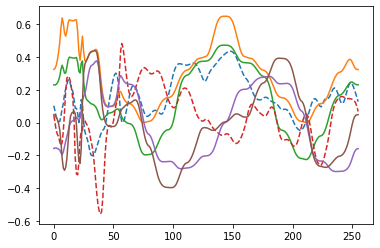

In [10]:
k = 10
for i in range(2):
    plt.plot(net(X_test)[k, i, :].detach(), '--')
    plt.plot(V_test[k, i, :])
    plt.plot(Y_test[k, i, :])

[0.00712366 0.00736931 0.01526314 0.01629109 0.01132551 0.07174638
 0.01634904 0.01624428 0.02246988 0.01029676 0.01690118 0.01465801
 0.00724208 0.00864977 0.00698406 0.01229745 0.01275998 0.00817698
 0.00697533 0.00688101 0.00795781 0.0077159  0.00379568]


Text(0, 0.5, 'Number of layers')

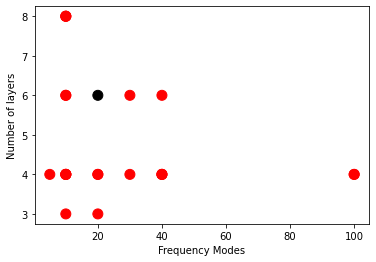

In [11]:
x = []
y = []
e = []

for i in range(2, 24):
    data = torch.load(path(i))
    settings = data["settings"]
    testloss = data["testloss"]
    n_f = len(settings.pop("input_features"))
    widths = settings.pop("layer_widths", None)
    if widths is None:
        depth = 4
    else:
        depth = len(widths)    
    err = np.mean(testloss[-100:])**0.5
    x.append(settings["modes"])
    y.append(depth)
    e.append(err)
    
for i in range(3, 4):
    data = torch.load(path2(i))
    settings = data["settings"]
    testloss = data["testloss"]
    n_f = len(settings.pop("input_features"))
    widths = settings.pop("layer_widths", None)
    if widths is None:
        depth = 4
    else:
        depth = len(widths)    
    err = np.mean(testloss[-100:])**0.5
    x.append(settings["modes"])
    y.append(depth)
    e.append(err)
    
e = np.array(e)
enorm = np.minimum(1, 80*(e-min(e))/(max(e)-min(e)))
#e = e / max(e)
c =  np.array([1,0,0])*enorm[:, None]
print(e)

plt.scatter(x, y, s=100, c=c)#s=5000 * testloss[-1]**0.5, c='black')
plt.xlabel("Frequency Modes")
plt.ylabel("Number of layers")

32


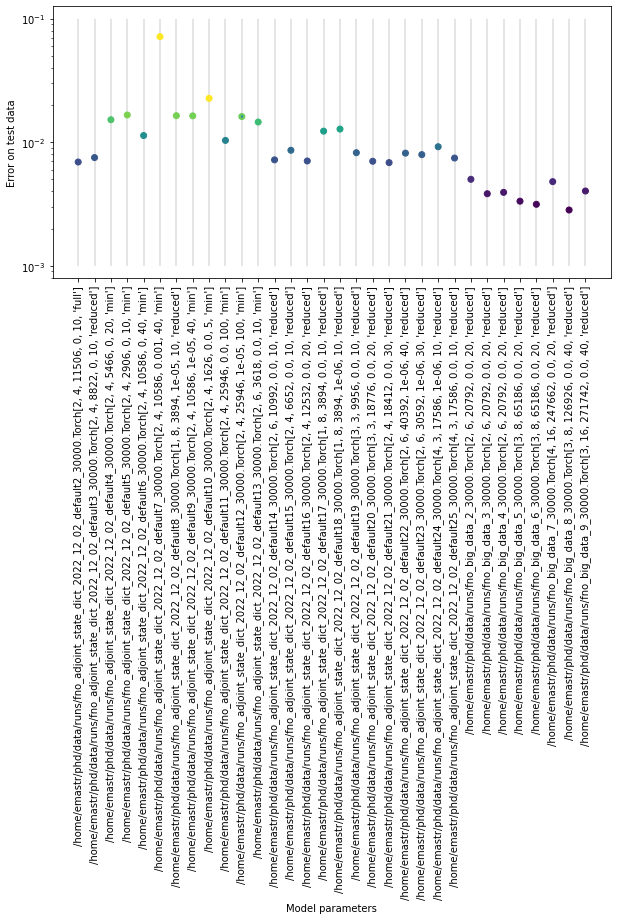

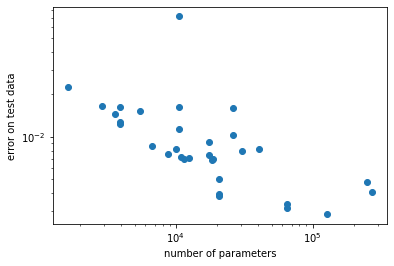

In [12]:
labels=[]
errs=[]
setts = []
ns = list(range(2,26))
N = len(ns)
ns2 = list(range(2,10))
paths = [path(i) for i in ns] + [path2(i) for i in ns2]
idx = list(range(len(ns)+len(ns2)))
plt.figure(figsize=(10,5))
for i in idx:
    data = torch.load(paths[i])
    settings = data["settings"]
    testloss = data["testloss"]
    if len(settings["input_features"]) == 4:
        settings["input"] = "min"
    elif len(settings["input_features"]) == 7:
        settings["input"] = "reduced"
    else:
        settings["input"] = "full"
    if "layer_widths" in settings.keys():
        settings["width"] = settings["layer_widths"][0] // len(settings["input_features"])
        settings["depth"] = len(settings["layer_widths"])
    else:
        settings["width"] = 2
        settings["depth"] = 4
    settings["weight_decay"] = settings.pop("weight_decay", 0)
    settings["num_par"] = sum([np.prod(s.shape) for s in data["state dict"].values()])
    
    #print(list(subdict(settings, {'input', 'width', 'depth'}).values()))
    err = np.mean(testloss[-1000:])**0.5 # last 100 epochs mean
    std = np.std(testloss[-1000:])
    plt.plot([i,i], [err-std, err+std])
    errs.append(err)
    plt.plot([i,i], [0.001, 0.1], 'black', linewidth=0.2, zorder=-1)
    labels.append(paths[i]+str(list(subdict(settings, {'input', 'width', 'depth', 'weight_decay', 'num_par', 'modes'}).values())))
    setts.append(subdict(settings, {'input', 'width', 'depth', 'weight_decay', 'num_par'}))


ns = idx
plt.scatter(ns, errs, c=np.minimum(errs, 0.02))
plt.yscale("log")
plt.xlabel("Model parameters")
plt.ylabel("Error on test data")
plt.xticks(ns, labels)
plt.gca().set_xticklabels(labels, rotation=90)

plt.figure()
#print(len())#
print(len(errs))

x = np.array([s["num_par"] for s in setts])
plt.scatter(x, errs)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("number of parameters")
plt.ylabel("error on test data")

None

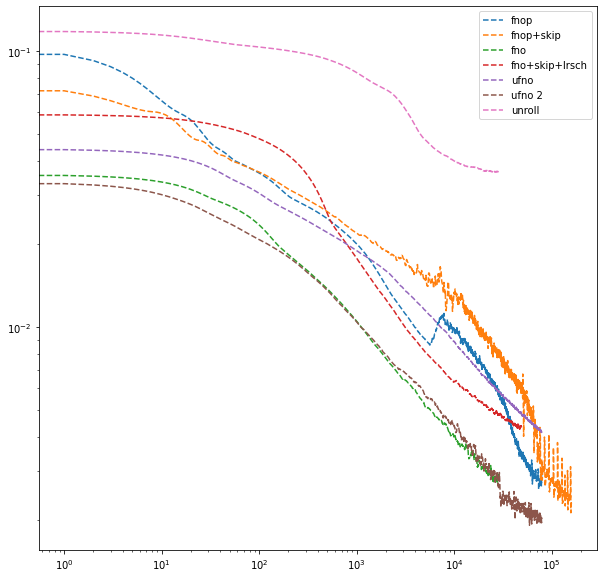

In [16]:
saves = [f"fnoproj_2_{80000}.Torch",
         f"fnoproj_4_{160000}.Torch",
         f"fno_big_data_8_{30000}.Torch",
         f"fnoskip_big_data_1_{50000}.Torch",
         f"ufno_2_{130000}.Torch",
         f"ufno_{100000}.Torch",
         f"unrolled_adjoint_state_dict_2022_11_25_conv_{30000}.Torch",        
        ]

saves = ["/home/emastr/phd/data/runs/" + s for s in saves]
names = ["fnop", "fnop+skip", "fno", "fno+skip+lrsch", "ufno", "ufno 2", "unroll"]


L = 1000

plt.figure(figsize=(10,10))
for i in range(len(saves)):
    save = torch.load(saves[i])
    loss = np.array(save["testloss"]) ** 0.5
    loss = np.convolve(loss, np.ones(L,)/L, mode='valid')
    plt.semilogy(loss, '--', label=names[i])

plt.xscale("log")
#plt.xlim([4e4, 8e4])
plt.legend()

In [17]:
import sys 
import os
import re

In [18]:
saves = os.listdir("../data/runs/")
matches = [True for s in saves]#[re.search("state_dict", s) for s in saves]
saves = [s for s,m in zip(saves, matches) if m is not None]
types = []
for s in saves:
    print(s)
    if s[0:4] == 'fnop':
        types.append(4)
    elif s[0:3] == 'fno':
        types.append(1)
    elif s[0:8] == 'unrolled':
        types.append(2)
    elif s[0:4] == "ufno":
        types.append(3)
    else:
        types.append(5)
        
print(types)

fno_adjoint_state_dict_2022_12_02_default13_19000.Torch
fnoproj_4_113000.Torch
fno_adjoint_state_dict_2022_12_02_default23_4000.Torch
fno_adjoint_state_dict_2022_12_02_default24_17000.Torch
fnoproj_37000.Torch
ufno_2_66000.Torch
fnoproj_3_0.Torch
fnoproj_2_77000.Torch
fno_adjoint_state_dict_2022_12_02_default24_9000.Torch
fno_adjoint_state_dict_2022_12_02_default17_22000.Torch
ufno_44000.Torch
fno_adjoint_state_dict_2022_12_02_default22_5000.Torch
fno_adjoint_state_dict_2022_12_02_default18_22000.Torch
fno_adjoint_state_dict_2022_12_02_default23_26000.Torch
fno_adjoint_state_dict_2022_12_02_default13_11000.Torch
fnoproj_33000.Torch
ufno_2_71000.Torch
fnoproj_2_70000.Torch
fno_adjoint_state_dict_2022_12_02_default16_29000.Torch
unrolled_adjoint_state_dict_2022_11_26_conv_12000.Torch
fno_big_data_6_28000.Torch
fno_adjoint_state_dict_2022_12_02_default12_8000.Torch
unrolled_adjoint_state_dict_2022_11_26_15lay_unet_23000.Torch
fno_big_data_4_9000.Torch
fnoproj_4_111000.Torch
unrolled_adjoi

5
10
16
35
63
64
65
66
67
103
112
120
152
173
184
188
194
197
203
225
227
244
254
261
262
282
292
306
319
344
361
371
373
376
391
409
432
442
455
457
480
481
494
503
516
543
552
560
561
577
595
599
609
617
622
631
639
649
650
659
671
684
741
759
761
762
838
840
876
878
879
906
922
925
936
952
954
962
974
980
1001
1009
1010
1012
1030
1061
1070
1088
1093
1113
1128
1135
1144
1155
1162
1191
1200
1207
1214
1224
1234
1268
1276
1302
1309
1315
1322
1324
1348
1352
1354
1385
1389
1421
1423
1443
1461
1468
1469
1494
1497
1516
1532
1534
1553
1556
1560
1568
1593
1600
1603
1630
1641
1655
1668
1698
1708
1719
1725
1731
1744
1745
1750
1756
1765
1767
1768
1773
1791
1806
1849
1850
1862
1878
1879
1883
1894
1911
1935
1947
1963
1976
1980
1987
1989
1995
2006
2040
2049
2057
2060
2067
2082
2083
2086
2093
2100
2105
2114
2126
2135
2139


[Text(2, 0, "[2, 4, 11506, 0, 'full']"),
 Text(3, 0, "[2, 4, 8822, 0, 'reduced']"),
 Text(4, 0, "[2, 4, 5466, 0, 'min']"),
 Text(5, 0, "[2, 4, 2906, 0, 'min']"),
 Text(6, 0, "[2, 4, 10586, 0, 'min']"),
 Text(7, 0, "[2, 4, 10586, 0.001, 'min']"),
 Text(8, 0, "[1, 8, 3894, 1e-05, 'reduced']"),
 Text(9, 0, "[2, 4, 10586, 1e-05, 'min']"),
 Text(10, 0, "[2, 4, 1626, 0.0, 'min']"),
 Text(11, 0, "[2, 4, 25946, 0.0, 'min']"),
 Text(12, 0, "[2, 4, 25946, 1e-05, 'min']"),
 Text(13, 0, "[2, 6, 3618, 0.0, 'min']"),
 Text(14, 0, "[2, 6, 10992, 0.0, 'reduced']"),
 Text(15, 0, "[2, 4, 6652, 0.0, 'reduced']"),
 Text(16, 0, "[2, 4, 12532, 0.0, 'reduced']"),
 Text(17, 0, "[1, 8, 3894, 0.0, 'reduced']"),
 Text(18, 0, "[1, 8, 3894, 1e-06, 'reduced']"),
 Text(19, 0, "[3, 3, 9956, 0.0, 'reduced']"),
 Text(20, 0, "[3, 3, 18776, 0.0, 'reduced']"),
 Text(21, 0, "[2, 4, 18412, 0.0, 'reduced']"),
 Text(22, 0, "[2, 6, 40392, 1e-06, 'reduced']"),
 Text(23, 0, "[2, 6, 30592, 1e-06, 'reduced']")]

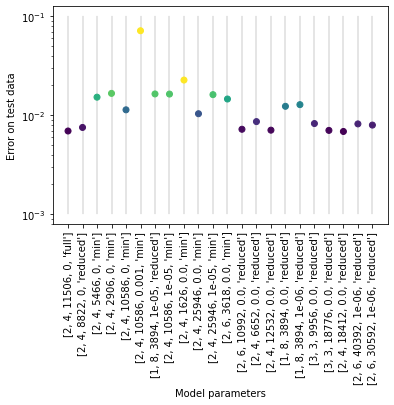

In [19]:
labels=[]
errs=[]
setts = []
type_list = []
ns = list(range(2,24))
N = len(ns)
for i in ns:
    data = torch.load(path(i))
    settings = data["settings"]
    testloss = data["testloss"]
    if len(settings["input_features"]) == 4:
        settings["input"] = "min"
    elif len(settings["input_features"]) == 7:
        settings["input"] = "reduced"
    else:
        settings["input"] = "full"
    if "layer_widths" in settings.keys():
        settings["width"] = settings["layer_widths"][0] // len(settings["input_features"])
        settings["depth"] = len(settings["layer_widths"])
    else:
        settings["width"] = 2
        settings["depth"] = 4
    settings["weight_decay"] = settings.pop("weight_decay", 0)
    settings["num_par"] = sum([np.prod(s.shape) for s in data["state dict"].values()])
    
    #print(list(subdict(settings, {'input', 'width', 'depth'}).values()))
    err = np.mean(testloss[-1000:])**0.5 # last 100 epochs mean
    errs.append(err)
    plt.plot([i,i], [0.001, 0.1], 'black', linewidth=0.2, zorder=-1)
    labels.append(str(list(subdict(settings, {'input', 'width', 'depth', 'weight_decay', 'num_par'}).values())))
    setts.append(subdict(settings, {'input', 'width', 'depth', 'weight_decay', 'num_par', 'modes'}))

    
num_pars = []
errs2 = []
for i in range(len(saves)):
    #print(saves[i], end="\n")
    try:
        data = torch.load(f"/home/emastr/phd/data/runs/{saves[i]}")
        testloss = data["testloss"]
        num_pars.append(sum([np.prod(s.shape) for s in data["state dict"].values()]))
        errs2.append(np.mean(testloss[-1000:])**0.5) # last 100 epochs mean
        type_list.append(types[i])
        if saves[i][0:4] == "ufno":
            print(i)
    except:
        continue


#print(saves)
plt.scatter(ns, errs, c=np.minimum(errs, 0.02))
plt.yscale("log")
plt.xlabel("Model parameters")
plt.ylabel("Error on test data")
plt.xticks(ns, labels)
plt.gca().set_xticklabels(labels, rotation=90)

(0.001, 1)

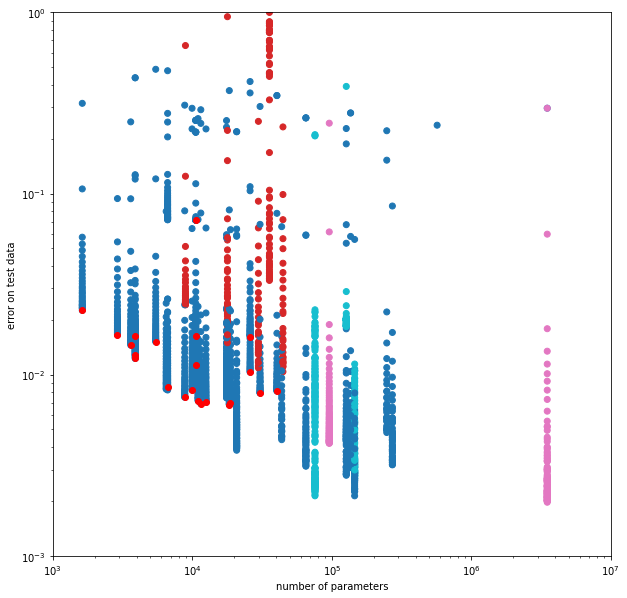

In [20]:
plt.figure(figsize=(10,10))
x = np.array([s["num_par"] for s in setts])
plt.scatter(num_pars, errs2, c=type_list, alpha=1, cmap="tab10")
plt.scatter(x, errs, c='red')
plt.yscale("log")
plt.xscale("log")
plt.xlabel("number of parameters")
plt.ylabel("error on test data")
plt.xlim([1e3,1e7])#([0,0.4*1e7])
plt.ylim([1e-3,1])
